# Reading and writing files with Loki

This is the first introductory notebook on how to work with Loki. The intention is to give an overview of how Fortran files can be read into Loki's internal representation to be able to work on their content and apply transformations, and how we can generate Fortran source code again. It includes a short peak at the control flow representation but details will be discussed in other notebooks.

Let's start by parsing the file `src/phys_mod.F90` from the `example` directory.
Loki uses a [_Sourcefile_](https://sites.ecmwf.int/docs/loki/main/loki.sourcefile.html#module-loki.sourcefile) object to represent an entire source file, which can contain modules or subroutines. To initialize the object with the content of a file on disc, we use the `from_file` class method:

In [1]:
from loki import Sourcefile
source = Sourcefile.from_file('src/phys_mod.F90', preprocess=True)
source

[Loki::Sourcefile] Constructed from src/phys_mod.F90 in 7.46s


Let's examine the content of the source file by looking at the modules and subroutines contained in that file:

In [2]:
print(f"Modules: {source.modules}")
print(f"Subroutines: {source.subroutines}")

Modules: (Module:: phys_mod,)
Subroutines: ()


We can see from the above that `source` contains one module by the name "phys_mod" and no free subroutines.
We can access modules either via their index in the `modules` property (i.e., `source.modules[0]`) or using a subscript operator with their name directly on the `Sourcefile` object:


In [3]:
phys_mod = source['phys_mod']
phys_mod

Module:: phys_mod

Fortran modules are represented as [_Module_](https://sites.ecmwf.int/docs/loki/main/loki.module.html#loki.module.Module) objects in Loki. They consist of a specification part and may contain, e.g., subroutines. Let's examine this object further:

In [4]:
print(f"Spec: {phys_mod.spec}")
print(f"Subroutines: {phys_mod.subroutines}")

Spec: Section::
Subroutines: (Subroutine:: phys_kernel_LITE_LOOP, Subroutine:: phys_kernel_VERT_SEARCH, Subroutine:: phys_kernel_NASTY_EXPS, Subroutine:: phys_kernel_LU_SOLVER, Subroutine:: phys_kernel_LU_SOLVER_COMPACT)


The specification part consists of a [_Section_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Section) node, which acts as the root node of Loki's control flow tree. At this point, it may be useful to learn more about Loki's internal representation by reading the [relevant part](https://sites.ecmwf.int/docs/loki/main/internal_representation.html) of the documentation. But for the objectives of this notebook we can also carry on and treat them as a black box for now.

To get an impression of what the IR of the specification part looks like, we can call `view()` on any of the nodes to print a representation of this node and the tree below it:

In [5]:
phys_mod.spec.view()

<Section::>
  <Import:: iso_fortran_env => ()>
  <Comment:: >
  <Import:: omp_lib => ()>
  <Comment:: >
  <Intrinsic:: IMPLICIT NONE>
  <Comment:: >
  <VariableDeclaration:: sp>
  <VariableDeclaration:: dp>
  <CommentBlock:: >
  <VariableDeclaration:: lp>
  <CommentBlock:: >
  <VariableDeclaration:: ip>
  <Comment:: >
  <VariableDeclaration:: cst1, cst2>
  <VariableDeclaration:: nspecies>
  <Comment:: >

Or alternativly, if `graphviz` is available, we can call `ir_graph()` on any of the nodes to view a graph representation of this node and the tree below it:

[Loki::Graph Visualization] Created graph visualization in 0.01s


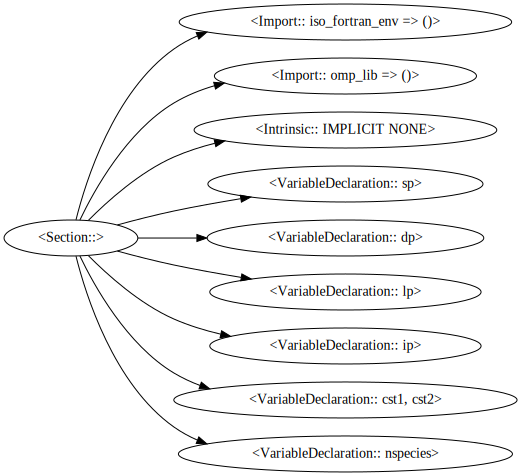

In [7]:
graph = None
try:
    graph = phys_mod.spec.ir_graph()
except ImportError:
    print("Install graphviz if you want to view the graph representation!")
graph

We can see a number of (empty) [comments](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Comment) - which are simply empty lines and retained to be able to produce Fortran code with a formatting similar to the original source. Since [comments](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Comment) might introduce additional noise, they are ignored by default in the graph representation. Other than that, we also have some [_Import_](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Import) statements, [preprocessor directives](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.PreprocessorDirective) and [declarations](https://sites.ecmwf.int/docs/loki/main/loki.ir.html#loki.ir.Declaration).

We can also convert this representation of the specification part back into a Fortran representation using the Fortran backend via [_fgen_](https://sites.ecmwf.int/docs/loki/main/loki.backend.fgen.html):

In [6]:
from loki import fgen
print(fgen(phys_mod.spec))

USE iso_fortran_env

USE omp_lib

IMPLICIT NONE

INTEGER, PARAMETER :: sp = REAL32
INTEGER, PARAMETER :: dp = REAL64



INTEGER, PARAMETER :: lp = dp!! lp : "local" precision


INTEGER, PARAMETER :: ip = INT64

REAL(KIND=lp) :: cst1 = 2.5, cst2 = 3.14
INTEGER, PARAMETER :: nspecies = 5



When comparing the Fortran code to the above internal representation makes it easy to identify the one-to-one correlation between IR nodes and statements in the original source code.

Let's pick out one of the kernel loops next:

In [7]:
lite_loop = phys_mod['phys_kernel_LITE_LOOP']
lite_loop

Subroutine:: phys_kernel_LITE_LOOP

Subroutines and functions are represented as a [_Subroutine_](https://sites.ecmwf.int/docs/loki/main/loki.subroutine.html#loki.subroutine.Subroutine) object. This allows, for example, to inspect the names of the dummy arguments expected by this routine:

In [8]:
lite_loop.argnames

['dim1',
 'dim2',
 'i1',
 'i2',
 'in1',
 'in2',
 'in3',
 'in4',
 'in5',
 'in6',
 'in7',
 'in8',
 'in9',
 'in10',
 'out1']

Furthermore, all subroutines contain a specification and body part (either of which can of course be empty in principal):

In [9]:
lite_loop.spec.view()

<Section::>
  <VariableDeclaration:: dim1, dim2, i1, i2>
  <VariableDeclaration:: in1(1:dim1, 1:dim2), in2(1:dim1, 1:dim2), in3(1:dim1, 1:dim2), 
  in4(1:dim1, 1:dim2), in5(1:dim1, 1:dim2), in6(1:dim1, 1:dim2), in7(1:dim1, 1:dim2), 
  in8(1:dim1, 1:dim2), in9(1:dim1, 1:dim2), in10(1:dim1, 1:dim2)>
  <VariableDeclaration:: out1(1:dim1, 1:dim2)>
  <Comment:: >
  <VariableDeclaration:: i, k>

In [10]:
lite_loop.body.view()

<Section::>
  <Loop:: k=1:dim2>
    <Loop:: i=i1:i2>
      <Assignment:: out1(i, k) = (in1(i, k) + in2(i, k) + in3(i, k) + in4(i, k) + in5(i, 
      k) + in6(i, k) + in7(i, k) + in8(i, k) + in9(i, k) + in10(i, k))*0.1>
      <Assignment:: in1(i, k) = out1(i, k)>

As we can see from the above, this kernel accepts a large number of arguments and consists essentially of two nested loops. Instead of viewing abstract representation, we can also produce Fortran source code again, either by calling `fgen` for individual parts or the entire `Subroutine` object, or, in this case, we can also use a convenience API offered by the object:

In [11]:
print(lite_loop.to_fortran())

SUBROUTINE phys_kernel_LITE_LOOP (dim1, dim2, i1, i2, in1, in2, in3, in4, in5, in6, in7, in8, in9, in10, out1)
  INTEGER(KIND=ip), INTENT(IN) :: dim1, dim2, i1, i2
  REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: in1, in2, in3, in4, in5, in6, in7, in8, in9, in10
  REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: out1
  
  INTEGER(KIND=ip) :: i, k
  DO k=1,dim2
    DO i=i1,i2
      out1(i, k) = (in1(i, k) + in2(i, k) + in3(i, k) + in4(i, k) + in5(i, k) + in6(i, k) + in7(i, k) + in8(i, k) + in9(i, k) +  &
      & in10(i, k))*0.1
      in1(i, k) = out1(i, k)
    END DO
  END DO
END SUBROUTINE phys_kernel_LITE_LOOP


In this notebook, we will not go into detail on how to actually modify the control flow tree of this routine. But we will extract this routine from the module and put it into a standalone module.

Let's start by creating a clone of this routine with a new name:

In [12]:
my_routine = lite_loop.clone(name='my_routine')
my_routine

Subroutine:: my_routine

Next, we create a new module and insert `my_routine` as a subroutine. To make sure the relevant declarations from the original module are available, we create a copy of the relevant spec:

In [13]:
from loki import Module
my_module = Module(name='my_module', spec=phys_mod.spec.clone(), contains=(my_routine,))
my_module

Module:: my_module

Let's ensure the new module contains `my_routine`:

In [14]:
assert len(my_module.subroutines) == 1
assert my_module.subroutines[0] is my_routine

We can also take a look at the Fortran code of this new module:

In [15]:
print(my_module.to_fortran())

MODULE my_module
  USE iso_fortran_env
  
  USE omp_lib
  
  IMPLICIT NONE
  
  INTEGER, PARAMETER :: sp = REAL32
  INTEGER, PARAMETER :: dp = REAL64
  
  
  
  INTEGER, PARAMETER :: lp = dp  !! lp : "local" precision
  
  
  INTEGER, PARAMETER :: ip = INT64
  
  REAL(KIND=lp) :: cst1 = 2.5, cst2 = 3.14
  INTEGER, PARAMETER :: nspecies = 5
  
  CONTAINS
  SUBROUTINE my_routine (dim1, dim2, i1, i2, in1, in2, in3, in4, in5, in6, in7, in8, in9, in10, out1)
    INTEGER(KIND=ip), INTENT(IN) :: dim1, dim2, i1, i2
    REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: in1, in2, in3, in4, in5, in6, in7, in8, in9, in10
    REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: out1
    
    INTEGER(KIND=ip) :: i, k
    DO k=1,dim2
      DO i=i1,i2
        out1(i, k) = (in1(i, k) + in2(i, k) + in3(i, k) + in4(i, k) + in5(i, k) + in6(i, k) + in7(i, k) + in8(i, k) + in9(i, k) + &
        &  in10(i, k))*0.1
        in1(i, k) = out1(i, k)
      END DO
    END DO
  END SUBROUTINE my_routi

And, ultimately, we can write this to a separate source file:

In [16]:
from pathlib import Path
Sourcefile.to_file(fgen(my_module), Path('my_module.F90'))

[Loki::Sourcefile] Writing to my_module.F90


Finally, let's take a peek at the generated file (disregard the pylint comment, which is there only for technical reasons related to our automated testing):

In [17]:
# pylint: disable=undefined-variable
%cat my_module.F90

MODULE my_module
  USE iso_fortran_env
  
  USE omp_lib
  
  IMPLICIT NONE
  
  INTEGER, PARAMETER :: sp = REAL32
  INTEGER, PARAMETER :: dp = REAL64
  
  
  
  INTEGER, PARAMETER :: lp = dp  !! lp : "local" precision
  
  
  INTEGER, PARAMETER :: ip = INT64
  
  REAL(KIND=lp) :: cst1 = 2.5, cst2 = 3.14
  INTEGER, PARAMETER :: nspecies = 5
  
  CONTAINS
  SUBROUTINE my_routine (dim1, dim2, i1, i2, in1, in2, in3, in4, in5, in6, in7, in8, in9, in10, out1)
    INTEGER(KIND=ip), INTENT(IN) :: dim1, dim2, i1, i2
    REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: in1, in2, in3, in4, in5, in6, in7, in8, in9, in10
    REAL(KIND=lp), INTENT(INOUT), DIMENSION(1:dim1, 1:dim2) :: out1
    
    INTEGER(KIND=ip) :: i, k
    DO k=1,dim2
      DO i=i1,i2
        out1(i, k) = (in1(i, k) + in2(i, k) + in3(i, k) + in4(i, k) + in5(i, k) + in6(i, k) + in7(i, k) + in8(i, k) + in9(i, k) + &
        &  in10(i, k))*0.1
        in1(i, k) = out1(i, k)
      END DO
    END DO
  END SUBROUTINE my_routi

Loki's documentation holds further details on [how to read files](https://sites.ecmwf.int/docs/loki/main/frontends.html) and additional options (choice of frontends, preprocessing) for that as well as the [different backends](https://sites.ecmwf.int/docs/loki/main/backends.html) that are available to generate code.